# Cardiovascular Disease Dataset


---


## The objective is to predict whether or not individual has a cardiovascular disease.

**Dataset Information**

The data set consists of a total of 11 features. The target variable is a binary value indicating whether or not a cardiovascular disease is present in the subject. <br>

**Feature Information**

Age | Objective Feature | age | int (days) | <br>
Height | Objective Feature | height | int (cm) | <br>
Weight | Objective Feature | weight | float (kg) | <br>
Gender | Objective Feature | gender | categorical code | 1: Women, 2: Men |<br>
Systolic blood pressure | Examination Feature | ap_hi | int | <br>
Diastolic blood pressure | Examination Feature | ap_lo | int |<br>
Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |<br>
Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |<br>
Smoking | Subjective Feature | smoke | binary |<br>
Alcohol intake | Subjective Feature | alco | binary |<br>
Physical activity | Subjective Feature | active | binary |<br>
Presence or absence of cardiovascular disease | Target Variable | cardio | binary |<br>

## 1. Import Dependencies


---



In [0]:
from google.colab import drive
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
import seaborn as sns

In [0]:
drive.mount('/content/drive/') 
path = '/content/drive/My Drive/Colab Notebooks/datasets/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## 2. Data pre-processing


---



### Import data

In [0]:
data = pd.read_csv(path + 'cardio_train.csv', header=None)

# each row is a set of 12 values separated by ';'
# first objective is to transform this into a dataframe with 1 value per cell

# gets list of all column names
col_names = str(data.iloc[0][0]).split(';')

# drops the 'id' column, which is basically an index
data.drop([0], inplace=True)
print(data.head())

                                        0
1   0;18393;2;168;62.0;110;80;1;1;0;0;1;0
2   1;20228;1;156;85.0;140;90;3;1;0;0;1;1
3   2;18857;1;165;64.0;130;70;3;1;0;0;0;1
4  3;17623;2;169;82.0;150;100;1;1;0;0;1;1
5   4;17474;1;156;56.0;100;60;1;1;0;0;0;0


### Cleanse Data

In [0]:
# create a dictionary
# indices are the keys and list of attributes are values
dictionary = {}

# iterate through rows
for index, row in data.iterrows():
    # at each row, split the values by delimiter ';''
    lst = str(row.values).split(';')
    lst = str(row.values[0]).split(';')
    
    # first value is id, so don't include it
    lst = list(lst[1:])
    # add to dicionary
    dictionary[index] = lst

In [0]:
# now convert dictionary into a dataframe
df = pd.DataFrame.from_dict(dictionary, orient='index')
# first column name was 'id', so don't include it
df.columns = col_names[1:]

In [0]:
# now the dataframe should be 12 columns, with a single value in each cell
pd.set_option('display.max_columns', None) # shows all columns
print(df.head())

     age gender height weight ap_hi ap_lo cholesterol gluc smoke alco active  \
1  18393      2    168   62.0   110    80           1    1     0    0      1   
2  20228      1    156   85.0   140    90           3    1     0    0      1   
3  18857      1    165   64.0   130    70           3    1     0    0      0   
4  17623      2    169   82.0   150   100           1    1     0    0      1   
5  17474      1    156   56.0   100    60           1    1     0    0      0   

  cardio  
1      0  
2      1  
3      1  
4      1  
5      0  


In [0]:
# up until this point, all values were chars/strings
# convert entire dataframe into numerical values
df = df.astype(float)

# age represented in days, convert approximate years
df['age'] = df['age'] // 365

In [0]:
print(df.describe())

                age        gender        height        weight         ap_hi  \
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000   
mean      52.840671      1.349571    164.359229     74.205690    128.817286   
std        6.766774      0.476838      8.210126     14.395757    154.011419   
min       29.000000      1.000000     55.000000     10.000000   -150.000000   
25%       48.000000      1.000000    159.000000     65.000000    120.000000   
50%       53.000000      1.000000    165.000000     72.000000    120.000000   
75%       58.000000      2.000000    170.000000     82.000000    140.000000   
max       64.000000      2.000000    250.000000    200.000000  16020.000000   

              ap_lo   cholesterol          gluc         smoke          alco  \
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000   
mean      96.630414      1.366871      1.226457      0.088129      0.053771   
std      188.472530      0.680250      0.572270    

In [0]:
# sys and di bp are incorrect, max/min are inaccurate vals
# highest recorded BP according to NCBI NLM study was 370/360
# adjust values accordingly
for val in df['ap_hi']:
    if(val > 370 or val < 0):
        df['ap_hi'].replace(val, 20000, inplace=True)

for val in df['ap_lo']:
    if(val > 360 or val < 0):
        df['ap_lo'].replace(val, 20000, inplace=True)

df = df[~(df[['ap_lo','ap_hi']] == 20000).any(axis=1)]
print(df.describe())

# at this point, any BP values that are greater than the highest records were dropped from the dataframe

                age        gender        height        weight         ap_hi  \
count  69000.000000  69000.000000  69000.000000  69000.000000  69000.000000   
mean      52.826754      1.348710    164.359725     74.118225    126.325145   
std        6.769551      0.476565      8.204221     14.328629     17.721845   
min       29.000000      1.000000     55.000000     11.000000      7.000000   
25%       48.000000      1.000000    159.000000     65.000000    120.000000   
50%       53.000000      1.000000    165.000000     72.000000    120.000000   
75%       58.000000      2.000000    170.000000     82.000000    140.000000   
max       64.000000      2.000000    250.000000    200.000000    309.000000   

              ap_lo   cholesterol          gluc         smoke          alco  \
count  69000.000000  69000.000000  69000.000000  69000.000000  69000.000000   
mean      81.332797      1.364377      1.225855      0.087870      0.053594   
std        9.877680      0.678695      0.571809    

## 3. Exploratory Data Analysis


---



In [0]:
# check target variable distribution
df['cardio'].value_counts()

0.0    34854
1.0    34146
Name: cardio, dtype: int64

### Age vs Number of Subjects with heart disease

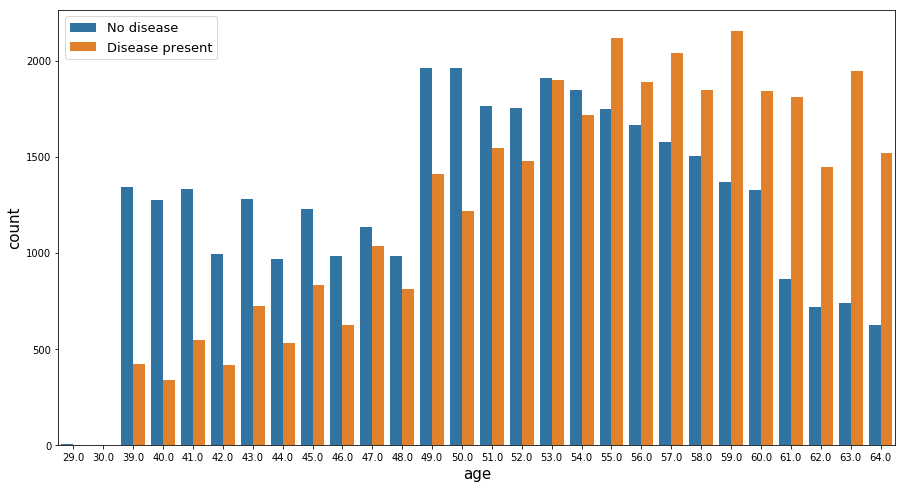

In [0]:
plt.figure(figsize=(15, 8))
sns.countplot(x='age', hue='cardio', data=df);

plt.ylabel('count', size=15)
plt.xlabel('age', size=15)

L = plt.legend(loc='upper left', prop={'size':13})
L.get_texts()[0].set_text('No disease')
L.get_texts()[1].set_text('Disease present')

In [0]:
# split data into subjects with/without cardiovascular disease
dis = df[df['cardio'] == 1] # subjects with disease
no_dis = df[df['cardio'] == 0] # subjects without disease

In [0]:
# group data by gender and cholesterol levels
# men with heart disease
dis_men_chol_1 = df[(df['gender'] == 2) & (df['cholesterol'] == 1)]
dis_men_chol_2 = df[(df['gender'] == 2) & (df['cholesterol'] == 2)]
dis_men_chol_3 = df[(df['gender'] == 2) & (df['cholesterol'] == 3)]

# women with heart disease
dis_women_chol_1 = df[(df['gender'] == 1) & (df['cholesterol'] == 1)]
dis_women_chol_2 = df[(df['gender'] == 1) & (df['cholesterol'] == 2)]
dis_women_chol_3 = df[(df['gender'] == 1) & (df['cholesterol'] == 3)]


# calculate means
men_chol_avgs = [ dis_men_chol_1['ap_hi'].mean(), dis_men_chol_2['ap_hi'].mean(), dis_men_chol_3['ap_hi'].mean() ]
women_chol_avgs = [ dis_women_chol_1['ap_hi'].mean(), dis_women_chol_2['ap_hi'].mean(), dis_women_chol_3['ap_hi'].mean() ]

### Systolic BP vs Cholesterol

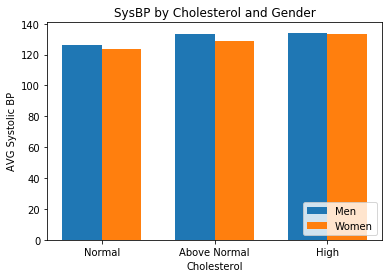

In [0]:
ind = np.arange(len(men_chol_avgs))
width = .35

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, men_chol_avgs, width, label='Men')
rects2 = ax.bar(ind + width/2, women_chol_avgs, width, label='Women')

ax.set_ylabel('AVG Systolic BP')

ax.set_xlabel('Cholesterol')
ax.set_xticks(ind)
ax.set_xticklabels(('Normal', 'Above Normal', 'High'))

ax.legend(loc='lower right')
ax.set_title('SysBP by Cholesterol and Gender')
plt.show()

### Glucose in smokers vs non smokers

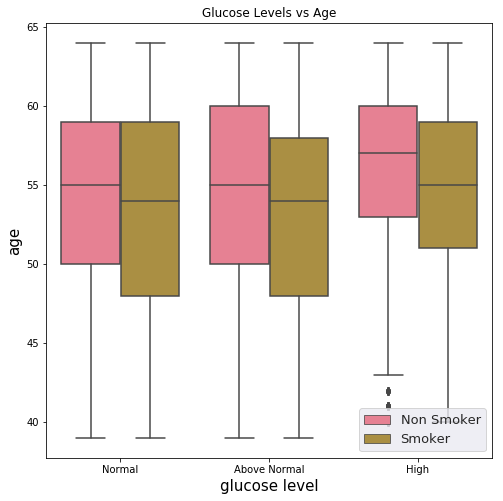

In [0]:
plt.figure(figsize=(8, 8))
plt.title('Glucose Levels vs Age')

sns.set(style="dark", palette="husl", color_codes=True)

sns.boxplot(x="gluc", y="age", hue="smoke", data=dis)
L = plt.legend(loc='lower right', prop={'size':13})
L.get_texts()[0].set_text('Non Smoker')
L.get_texts()[1].set_text('Smoker')

plt.ylabel('age', size=15)
plt.xlabel('glucose level', size=15)

plt.xticks([0, 1, 2], ['Normal', 'Above Normal', 'High'])
plt.show()

### BP and Cholesterol distributions in individuals who are healthy vs individuals with disease

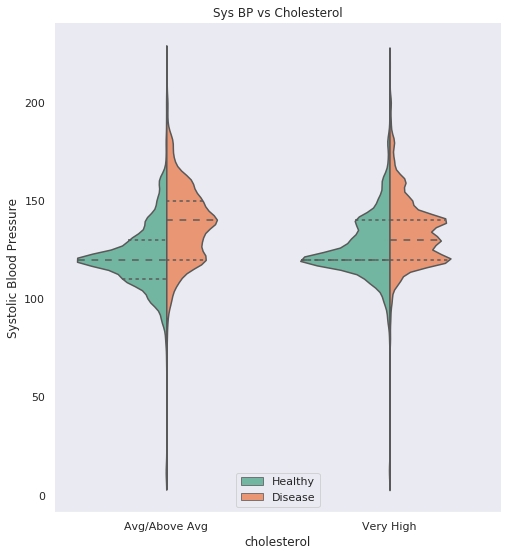

In [0]:
df_high_chol = df[(df['cholesterol'] > 1) & (df['gluc'] > 1)]

plt.figure(figsize=(8,9))

sns.set(style="dark", palette="Set2", color_codes=True)

sns.violinplot(x="cholesterol", y="ap_hi", hue="cardio", split=True, inner="quart", data=df_high_chol)

plt.xticks([0, 1], ['Avg/Above Avg', 'Very High'])
plt.ylabel('Systolic Blood Pressure')

L = plt.legend(loc='lower center')
L.get_texts()[0].set_text('Healthy')
L.get_texts()[1].set_text('Disease')

plt.title('Sys BP vs Cholesterol')

sns.despine(left=True)

## 4. Model


---

The model is a densely connected feed forward Neural Network. 

In [0]:
X = df.drop('cardio', axis=1)
y = df['cardio']

---
### Activation Functions:
**relu**
<br> The vanishing gradient problem: the gradients of some activation functions becoming increasingly smaller as the number of hidden layers increases. This is problematic because the parameters in the neural network won't be tuned effectively.
<br>ReLU overcomes this problem. Formula:
>$R(x) = 
 \begin{Bmatrix}
  x & x > 0 \\
  0 & x <= 0 
 \end{Bmatrix}$<br>
 
Since the ReLU has a range of [0, $\infty$], gradients won't diminish.

**sigmoid**
<br>Activation function used in the output layer. Effective for classification problems. Formula:
>$S(x) = \LARGE\frac{1}{1+e^{-x}}$

---

### Loss Function:
**Binary Crossentropy**
<br>Cross entropy is calculated by finding the predicted probability (the probability of classification being correct based on given data). Larger predicted probabilities yeild lower losses. Formula:
>$Loss = −(y\cdot log(p)+(1−y) \cdot log(1−p))$
><br>y: whether or not classification was correct
><br>p: predicted probability

The only difference between the cross entropy and binary cross entropy loss functions is that binary cross entropy includes a sigmoid activation function.

---
### Optmization Function:
**Adam Optmizier**
<br> Calculates adaptive learning rates for each parameter. First computes exponentially weighted average of:
1. past gradients
2. past square gradients

This gives us the mean, and variance of the gradients. These averages have a bias towards 0, so after the bias is corrected, the parameters are updated.

---

In [0]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape = (11,) ))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
model.fit(X, y, epochs=10, batch_size=32, validation_split = .2)

Train on 55200 samples, validate on 13800 samples
Epoch 1/10
55200/55200 [==============================] - 6s 106us/sample - loss: 0.6025 - acc: 0.6891 - val_loss: 0.5791 - val_acc: 0.7024
Epoch 2/10
55200/55200 [==============================] - 6s 103us/sample - loss: 0.5779 - acc: 0.7070 - val_loss: 0.5854 - val_acc: 0.6954
Epoch 3/10
55200/55200 [==============================] - 6s 105us/sample - loss: 0.5740 - acc: 0.7111 - val_loss: 0.5745 - val_acc: 0.7094
Epoch 4/10
55200/55200 [==============================] - 6s 105us/sample - loss: 0.5707 - acc: 0.7129 - val_loss: 0.5708 - val_acc: 0.7135
Epoch 5/10
55200/55200 [==============================] - 6s 103us/sample - loss: 0.5689 - acc: 0.7139 - val_loss: 0.5711 - val_acc: 0.7128
Epoch 6/10
55200/55200 [==============================] - 6s 103us/sample - loss: 0.5679 - acc: 0.7145 - val_loss: 0.5725 - val_acc: 0.7120
Epoch 7/10
55200/55200 [==============================] - 6s 103us/sample - loss: 0.5665 - acc: 0.7151 - val_l

 **Accuracy on validation data: 71.75%**